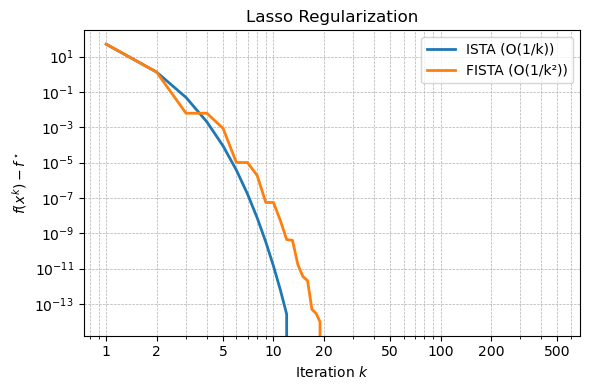

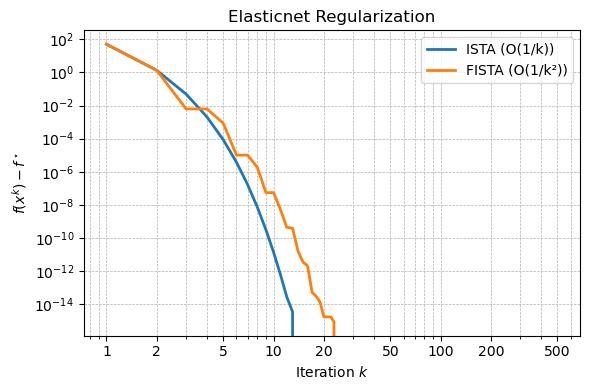

,method,regularizer,n_iter,time_s,f_final,error_norm
0,ISTA,lasso,500,0.022075,4.620563,9.370669
1,FISTA,lasso,500,0.021117,4.620563,9.370669
2,ISTA,elasticnet,500,0.023366,5.635365,9.371018
3,FISTA,elasticnet,500,0.022697,5.635365,9.371018


In [1]:
# imports
from easy_boston_data import generate_easy_boston_like_data
from iterative_solvers import ista, fista
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# 1) data gen + standardization
A, b, x_true = generate_easy_boston_like_data(m=800, seed=42, noise_std=0.1)
A_mean, A_std = A.mean(axis=0), A.std(axis=0)
A = (A - A_mean) / A_std
b = b - b.mean()

# 2) only Lasso & Elastic-Net
reg_settings = [
    {"name": "lasso",      "alpha1": 0.1, "alpha2": 0.0},
    {"name": "elasticnet", "alpha1": 0.1, "alpha2": 0.1},
]

records = []

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    # ISTA
    t0 = time.perf_counter()
    x_ista, obj_ista = ista(A, b,
                             reg_type=name,
                             alpha1=a1,
                             alpha2=a2,
                             max_iter=500)
    t_ista = time.perf_counter() - t0

    # FISTA
    t0 = time.perf_counter()
    x_fista, obj_fista = fista(A, b,
                               reg_type=name,
                               alpha1=a1,
                               alpha2=a2,
                               max_iter=500)
    t_fista = time.perf_counter() - t0

    # approximate best f*
    f_star = obj_fista[-1]

    # --- compute the gaps (full length) ---
    gap_ista  = np.array(obj_ista)  - f_star
    gap_fista = np.array(obj_fista) - f_star

    # --- build envelope = running minimum (monotone decay) ---
    env_ista  = np.minimum.accumulate(gap_ista)
    env_fista = np.minimum.accumulate(gap_fista)

    # --- full iteration axis to max_iter (here 500) ---
    K = len(env_ista)
    ks = np.arange(1, K+1)

    # --- plot envelopes only, smooth lines, no markers ---
    fig, ax = plt.subplots(figsize=(6,4))
    ax.loglog(ks, env_ista,  '-', label="ISTA (O(1/k))", linewidth=2)
    ax.loglog(ks, env_fista, '-', label="FISTA (O(1/k²))", linewidth=2)

    ax.set_title(f"{name.title()} Regularization")
    ax.set_xlabel("Iteration $k$")
    ax.set_ylabel(r"$f(x^k)-f^\star$")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

    # --- nice integer ticks at 1,2,5,10,20,50,100,500 ---
    from matplotlib.ticker import LogLocator, FormatStrFormatter
    ax.xaxis.set_major_locator(LogLocator(base=10, subs=[1,2,5]))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(1,10), numticks=12))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    plt.tight_layout()
    plt.show()


    # record summary stats
    records.append({
        "method":      "ISTA",
        "regularizer": name,
        "n_iter":      len(obj_ista),
        "time_s":      t_ista,
        "f_final":     obj_ista[-1],
        "error_norm":  np.linalg.norm(x_ista - x_true)
    })
    records.append({
        "method":      "FISTA",
        "regularizer": name,
        "n_iter":      len(obj_fista),
        "time_s":      t_fista,
        "f_final":     obj_fista[-1],
        "error_norm":  np.linalg.norm(x_fista - x_true)
    })

# big summary DataFrame
df_summary = pd.DataFrame(records)
df_summary
